In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd drive/MyDrive/SIAP/dataset/clean

In [123]:
import numpy as np
import pandas as pd
from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, Input, MaxPooling1D

from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

from tensorflow.keras.optimizers import Adam

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 15889 
EMBEDDING_DIM = 300

VALIDATION_SPLIT = 0.1
BATCH_SIZE = 128
EPOCHS = 5

In [124]:
train = pd.read_csv('train_clean_removed_emoticons.csv')
sentences = train["Review Text"].fillna("DUMMY_VALUE").values
possible_labels = list(set(train["Rating"]))
y = train["Rating"].values
targets = to_categorical(y)

In [125]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.add('dress')
stop_words.add('petite')
stop_words.add('jacket')
stop_words.add('blazer')

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ')             #1
    words = tokenizer.tokenize(txt)                     #2
    words = [w for w in words if not w in stop_words]   #3
    #words = [ps.stem(w) for w in words]                #4 with stemming we end up with even worse results 
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower()                                                     # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)                               # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text)                                     # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

train['Cleaned_Review_Text'] = train['Review Text'].apply(clean_text)

In [127]:
new_str = [str(x) for x in train['Cleaned_Review_Text']]

df = pd.DataFrame(new_str)
temp = []
for i in range(len(df)):
  temp.append(preprocessing(df.iloc[i]))

In [128]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(temp)
sequences = tokenizer.texts_to_sequences(temp)
s = sorted(len(s) for s in sequences)
word2idx = tokenizer.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)

# Loading pretrained embeding (Globe.6B.300d Stanford)

In [129]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [130]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [131]:
embedding_layer = Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

In [132]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# --------------------------------------
x = Conv1D(256, 3, activation="relu")(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(possible_labels) + 1, activation="softmax")(x)

model = Model(input_, output)
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"],
)

In [133]:
r = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

Epoch 1/5
128/128 [==============================] - 4s 22ms/step - loss: 1.2222 - accuracy: 0.5478 - val_loss: 1.0150 - val_accuracy: 0.5922
Epoch 2/5
128/128 [==============================] - 2s 19ms/step - loss: 0.9746 - accuracy: 0.6001 - val_loss: 0.9555 - val_accuracy: 0.6104
Epoch 3/5
128/128 [==============================] - 3s 20ms/step - loss: 0.9095 - accuracy: 0.6244 - val_loss: 0.9460 - val_accuracy: 0.6164
Epoch 4/5
128/128 [==============================] - 2s 19ms/step - loss: 0.8389 - accuracy: 0.6520 - val_loss: 0.9761 - val_accuracy: 0.6015
Epoch 5/5
128/128 [==============================] - 2s 19ms/step - loss: 0.7709 - accuracy: 0.6814 - val_loss: 0.9833 - val_accuracy: 0.6159


In [134]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [135]:
print(confusion_matrix(y, y_pred))

[[ 134  369  106   12   36]
 [  20  618  451   66   82]
 [   3  310 1369  304  275]
 [   1   47  521 1421 1930]
 [   2   22   99  269 9646]]


In [136]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.20      0.33       657
           2       0.45      0.50      0.47      1237
           3       0.54      0.61      0.57      2261
           4       0.69      0.36      0.47      3920
           5       0.81      0.96      0.88     10038

    accuracy                           0.73     18113
   macro avg       0.66      0.53      0.54     18113
weighted avg       0.72      0.73      0.70     18113



In [137]:
print(f1_score(y, y_pred, average="micro"))

0.728095842764865


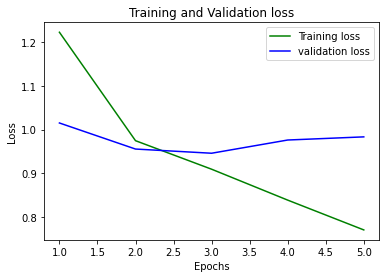

In [138]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = r.history['loss']
loss_val = r.history['val_loss']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [139]:
test = pd.read_csv('test_clean_removed_emoticons.csv')
test_text = test["Review Text"].values
test_text = [str(x).lower() for x in test_text]

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

y_test = test["Rating"].values

In [140]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [141]:
print(confusion_matrix(y_test, y_pred))

[[   7   26   24   11   14]
 [   3   43   64   12   33]
 [   2   45  103   44   86]
 [   1   11   78   94  309]
 [   0   10   51   84 1108]]


In [142]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.09      0.15        82
           2       0.32      0.28      0.30       155
           3       0.32      0.37      0.34       280
           4       0.38      0.19      0.25       493
           5       0.71      0.88      0.79      1253

    accuracy                           0.60      2263
   macro avg       0.46      0.36      0.37      2263
weighted avg       0.56      0.60      0.56      2263



In [146]:
print(f1_score(y_test, y_pred, average="micro"))

0.5987627043747238
